# 图像分类（二分类）

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\13936\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [5]:
# 数据集的具体路径结构如下

In [6]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [7]:
# 训练集路径
train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
#验证集路径
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [10]:
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [11]:
# 1、从磁盘读取图像。
# 2、解码这些图像的内容，并根据其RGB内容将其转换为正确的网格格式。
# 3、将它们转换为浮点张量。
# 4、将张量从0到255之间的值重新缩放为0到1之间的值，因为神经网络更喜欢处理较小的输入值。
# 这些都可以通过tf.keras提供的ImageDataGenerator类完成。
# 它可以从磁盘读取图像并将其预处理为适当的张量。 
# 它还将设置将这些图像转换成张量的生成器，这对于训练网络很有帮助。

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255) 

In [13]:
# 在定义了用于训练和验证图像的生成器之后，flow_from_directory方法从磁盘加载图像，应用重新缩放，然后将图像调整为所需的尺寸。

In [14]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [15]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [16]:
# 通过从训练生成器中提取一批图像（在此示例中为32张图像）来可视化训练图像，然后使用matplotlib绘制其中的五幅。

In [17]:
sample_training_images, _ = next(train_data_gen)

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

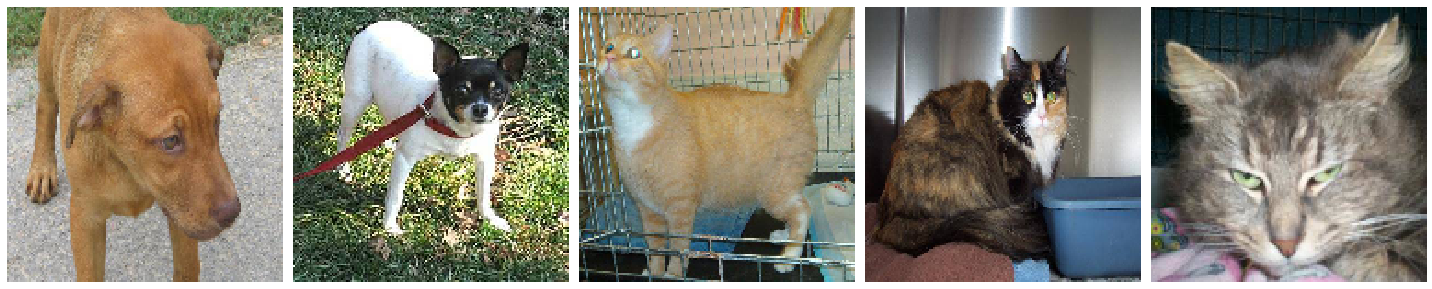

In [106]:
plotImages(sample_training_images[:5])

In [16]:
# 该模型由三个卷积块组成，每个卷积块中都有一个最大池层。 有一个完全连接的层，上面有512个单元，可通过relu激活功能激活。
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

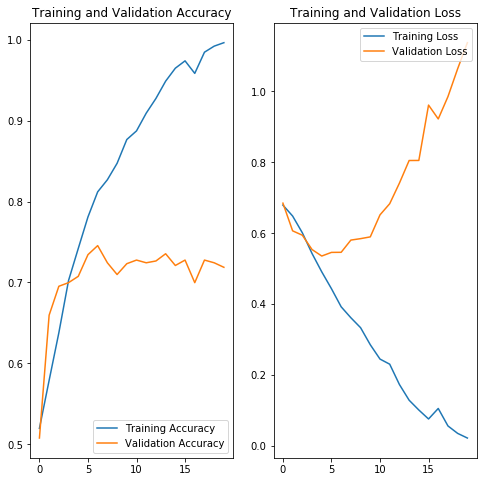

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 在上面的图中，训练精度随时间呈线性增长，而验证精度在训练过程中停滞在70％左右。
# 同样，训练和验证准确性之间的准确性差异也很明显，这是过度拟合的标志。
# 当训练样本数量很少时，模型有时会从训练样本的噪音或不必要的细节中学习，以至于对模型在新样本上的性能产生负面影响。
# 这种现象称为过拟合。 这意味着该模型很难推广到新的数据集。
# 在训练过程中，有多种方法可以解决过拟合的问题。 
# 接下来将使用数据扩充并将遗漏添加到模型中。

In [ ]:
# 首先将随机水平翻转增强（horizontal_flip）应用于数据集，然后查看变换后各个图像的外观。

In [153]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [165]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


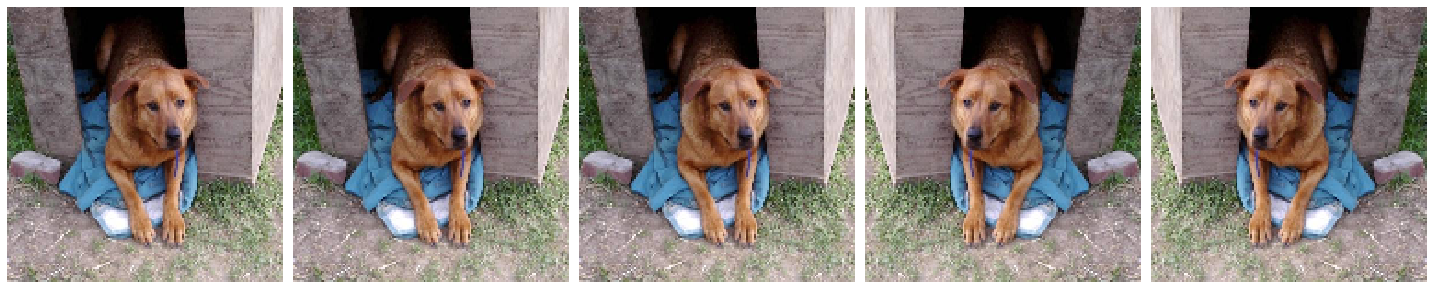

In [166]:
plotImages(augmented_images)

In [ ]:
# 让我们看一下另一种称为旋转的增强，然后将45度旋转随机应用于训练示例。

In [62]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [65]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


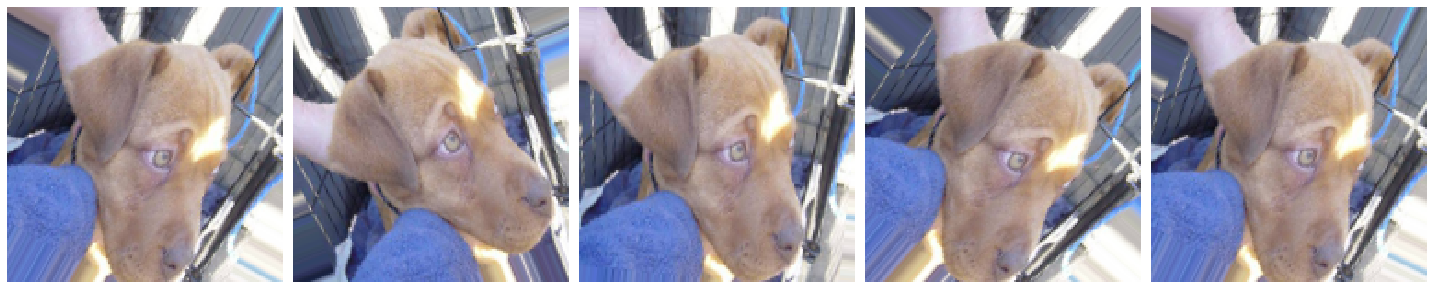

In [66]:
plotImages(augmented_images)

In [ ]:
# 将缩放增强应用于数据集以将图像随机缩放到50％。

In [67]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [68]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


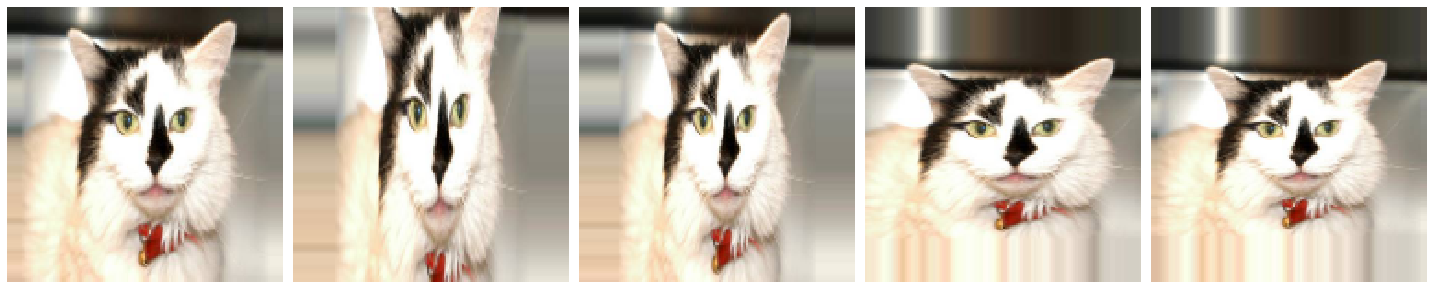

In [69]:
plotImages(augmented_images)

In [70]:
# 对训练图像应用了重新缩放，45度旋转，宽度偏移，高度偏移，水平翻转和缩放增强。
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [71]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


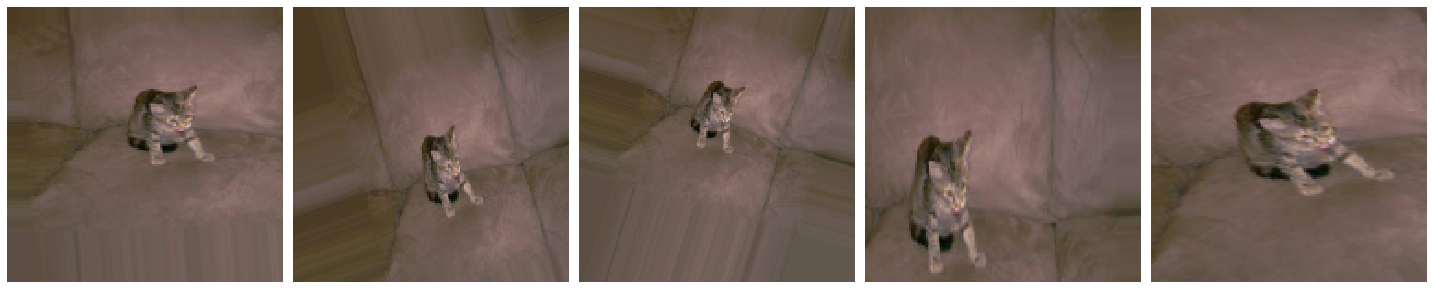

In [72]:
# 可视化当将这些增强随机传递到数据集时，单个图像在五个不同时间的外观。
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [73]:
# 通常，仅将数据扩充应用于训练示例。 在这种情况下，仅重新缩放验证图像，然后使用ImageDataGenerator将其转换为批次。
image_gen_val = ImageDataGenerator(rescale=1./255)

In [74]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [75]:
# Dropout是另一种防止过拟合的方法
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [76]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [77]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/20
15/15 [==============================] - 40s 3s/step - loss: 1.4614 - accuracy: 0.5042 - val_loss: 0.6957 - val_accuracy: 0.4978
Epoch 2/20
15/15 [==============================] - 38s 3s/step - loss: 0.6916 - accuracy: 0.5063 - val_loss: 0.7066 - val_accuracy: 0.5826
Epoch 3/20
15/15 [==============================] - 40s 3s/step - loss: 0.6959 - accuracy: 0.5021 - val_loss: 0.6902 - val_accuracy: 0.4978
Epoch 4/20
15/15 [==============================] - 38s 3s/step - loss: 0.6893 - accuracy: 0.4979 - val_loss: 0.6849 - val_accuracy: 0.5592
Epoch 5/20
15/15 [==============================] - 41s 3s/step - loss: 0.6916 - accuracy: 0.5016 - val_loss: 0.6875 - val_accuracy: 0.4978
Epoch 6/20
15/15 [==============================] - 39s 3s/step - loss: 0.6896 - accuracy: 0.5016 - val_loss: 0.6844 - val_accuracy: 0.4978
Epoch 7/20
15/15 [==============================] - 38s 3s/step - los

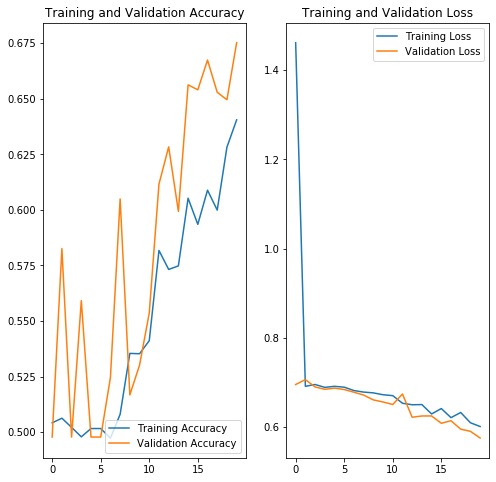

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 训练后可视化新模型，您会发现过拟合明显少于以前。
# 在训练模型更多的时间后，准确性应该会提高。